## 10.3 RNN을 이용한 문서 분류 - NLTK 영화 리뷰 감성분석

### 10.3.1 워드 임베딩을 위한 데이터 준비

In [2]:
from nltk.corpus import movie_reviews
fileids = movie_reviews.fileids()  # 영화 리뷰 데이터에서 파일 id를 가져옴

# 파일 id를 이용해 raw 텍스트 파일을 가져옴
reviews = [ movie_reviews.raw(fileid) for fileid in fileids ]

# 파일 id를 이용해 라벨로 사용할 카테고리, 즉 긍정/부정 정보를 순서대로 가져옴
categories = [ movie_reviews.categories(fileid)[0] for fileid in fileids ]

print('Reviews count : ', len(reviews))
print('Length of the first review : ', len(reviews[0]))
print('Labels : ', set(categories))

Reviews count :  2000
Length of the first review :  4043
Labels :  {'pos', 'neg'}


In [3]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000  # 사용할 단어의 수

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')  # 사전에 포함되지 않는 단어를 UNK로 변환

tokenizer.fit_on_texts(reviews)  # 단어 인덱스 사전 구축

# 만들어진 단어 인덱스 사전(fit_on_texts)을 이용해 문서들을 반환
X = tokenizer.texts_to_sequences(reviews)

print('Length of first 10 documents : ', [ len(doc) for doc in X[:10] ])

Length of first 10 documents :  [710, 240, 486, 479, 733, 671, 550, 584, 702, 776]


In [4]:
import numpy as np
print('Index of "the":', tokenizer.word_index["the"])  # tokenizer가 생성한 사전에서 the의 인덱스 확인
print('Index of "review":', tokenizer.word_index["review"])
print('Index of Out Of Vocabulary words:', tokenizer.word_index["UNK"])

Index of "the": 2
Index of "review": 466
Index of Out Of Vocabulary words: 1


In [6]:
from keras.utils import pad_sequences

maxlen=500  # 문서의 단어 수를 제한

# 문서의 단어 수가 500보다 작으면 0을 채우고, 크면 잘라냄
# 잘라낼 때, 앞을 자를 지, 뒤를 자를 지, 선택할 수 있음.
# 앞을 자르고 뒷부분을 쓰고 싶으면 truncating='pre' 선택
X = pad_sequences(X, maxlen=maxlen, truncating='pre')

In [11]:
import numpy as np

# label을 0,1 값으로 반환
label_dict = {'pos':1, 'neg':0}
y = np.array([ label_dict[c] for c in categories ])
print(set(y))

{0, 1}


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train set Count :', len(X_train))
print('Test set Count :', len(X_test))
print('Test Samples :', y_test[:20])

Train set Count : 1600
Test set Count : 400
Test Samples : [0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1]


### 10.3.2 RNN이 아닌 일반적인 신경망 모형을 이용한 분류

In [13]:
# 케라스 모형 생성 및 학습
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

# 순차적 모형
model = Sequential()

# word embedding layer 생성
# max_words는 원핫 인코딩 할 때의 벡터 크기가 됨.
# 각 단어는 32 크기의 dense vector로 임베딩됨
# input_length는 하나의 document의 단어 수로 표현
# 이 과정을 거치면 각 document는 (maxlen, 32)의 2차원 행렬이 됨 
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Flatten())  # 2차원 행렬을 1차원으로 펼침
model.add(Dense(1, activation='sigmoid'))  # 이항 로지스틱 회귀분석을 수행

model.summary()  # 모델의 요약 정보 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 1)                 16001     
                                                                 
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 모형의 옵티마이저와 손실함수 등을 지정
model.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

# 학습을 수행
history = model.fit(
    X_train, y_train,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Epoch 1/10
40/40 [==============================] - 13s 41ms/step - loss: 0.6911 - acc: 0.5391 - val_loss: 0.6885 - val_acc: 0.5125
Epoch 2/10
40/40 [==============================] - 0s 11ms/step - loss: 0.6136 - acc: 0.9008 - val_loss: 0.6804 - val_acc: 0.5844
Epoch 3/10
40/40 [==============================] - 0s 10ms/step - loss: 0.5098 - acc: 0.9648 - val_loss: 0.6643 - val_acc: 0.5875
Epoch 4/10
40/40 [==============================] - 0s 13ms/step - loss: 0.3776 - acc: 0.9914 - val_loss: 0.6424 - val_acc: 0.6156
Epoch 5/10
40/40 [==============================] - 0s 9ms/step - loss: 0.2493 - acc: 0.9977 - val_loss: 0.6202 - val_acc: 0.6500
Epoch 6/10
40/40 [==============================] - 0s 11ms/step - loss: 0.1494 - acc: 0.9984 - val_loss: 0.6104 - val_acc: 0.6344
Epoch 7/10
40/40 [==============================] - 0s 8ms/step - loss: 0.0841 - acc: 1.0000 - val_loss: 0.6014 - val_acc: 0.6562
Epoch 8/10
40/40 [==============================] - 0s 8ms/step - loss: 0.0454 - acc

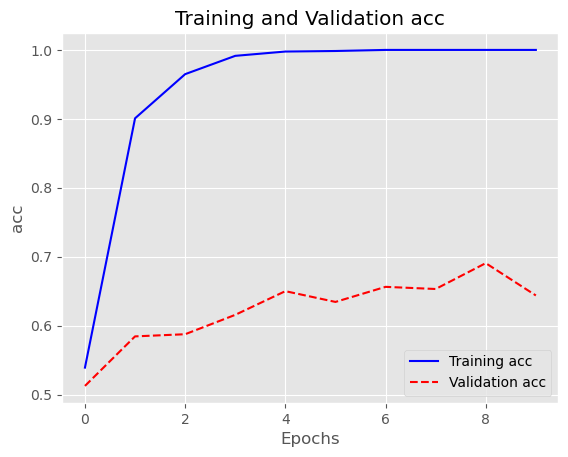

13/13 [==============================] - 0s 16ms/step - loss: 0.6048 - acc: 0.6875
#Test accuracy : 0.688


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+ metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation ' + metric)
    plt.title('Training and Validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show();
    
plot_results(history, 'acc')

# 테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print('#Test accuracy : {:.3f}'.format(score[1]))

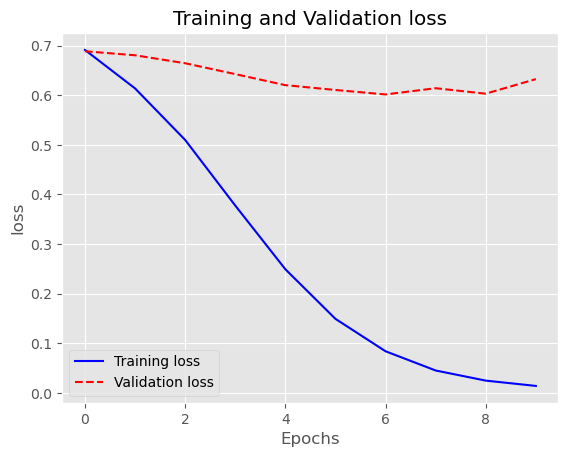

In [21]:
plot_results(history, 'loss')

### 10.3.3 문서의 순서정보를 활용하는 RNN 기반 문서 분류

In [22]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(max_words, 32))

# Flatten() layer 사용X, maxlen만큼의 시계열 데이터
model.add(SimpleRNN(32))  # 은닉노드 크기, 
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

adam = Adam(learning_rate=1e-4)
model.compile(
    optimizer = adam,
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

history = model.fit(
    X_train, y_train,
    epochs = 10,
    verbose = 0,
    validation_split = 0.2
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 323,169
Trainable params: 323,169
Non-trainable params: 0
_________________________________________________________________


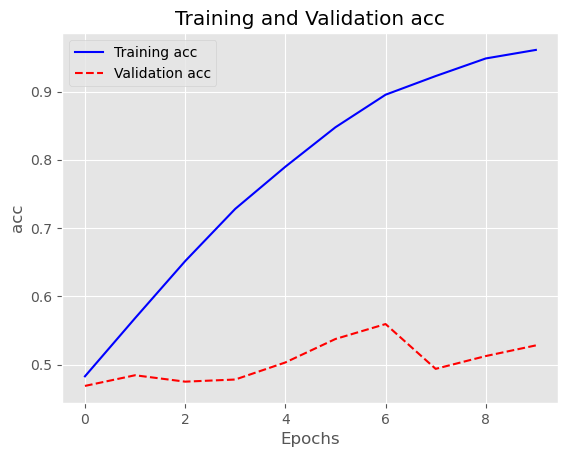

13/13 [==============================] - 1s 39ms/step - loss: 0.7128 - acc: 0.5150
#Test accuracy : 0.515


In [23]:
plot_results(history, 'acc')

# 테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print('#Test accuracy : {:.3f}'.format(score[1]))

## 10.4 LSTM, Bi-LSTM, GRU를 이용한 성능 개선

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714,369
Trainable params: 714,369
Non-trainable params: 0
_________________________________________________________________


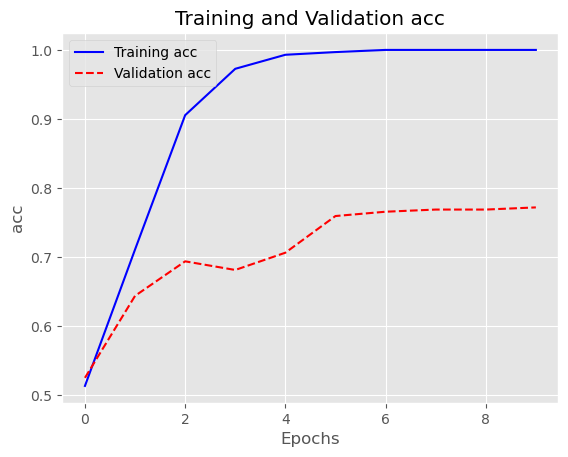

13/13 [==============================] - 4s 142ms/step - loss: 1.0509 - acc: 0.7725
#Test accuracy : 0.772


In [26]:
from tensorflow.keras.layers import LSTM, Bidirectional

model = Sequential([
    Embedding(max_words, 64),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    verbose=0,
    validation_split = 0.2
)

plot_results(history, 'acc')

# 테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print('#Test accuracy : {:.3f}'.format(score[1]))

In [27]:
y_pred = np.round(model.predict(X_test[:10]))

for pred, y_t in zip(y_pred, y_test[:10]):
    print(
        f'predicted value : {pred[0]}, true value : {y_t}, so the prediction is {pred[0] == y_t}'
    )

1/1 [==============================] - 4s 4s/step
predicted value : 0.0, true value : 0, so the prediction is True
predicted value : 1.0, true value : 1, so the prediction is True
predicted value : 1.0, true value : 1, so the prediction is True
predicted value : 0.0, true value : 0, so the prediction is True
predicted value : 0.0, true value : 1, so the prediction is False
predicted value : 1.0, true value : 1, so the prediction is True
predicted value : 0.0, true value : 0, so the prediction is True
predicted value : 1.0, true value : 0, so the prediction is False
predicted value : 0.0, true value : 0, so the prediction is True
predicted value : 0.0, true value : 0, so the prediction is True
